In [0]:
#########     preparation block       #########
#   install mne package & upload eeg data files
###############################################
!pip install mne

from google.colab import files
uploaded = files.upload()

     |████████████████████████████████| 6.6MB 2.7MB/s 


Saving EEG_Data_03.eeg to EEG_Data_03.eeg


In [0]:
###   data loading block   ###
import os
import sys
import mne
import matplotlib.pyplot as plt
import time
plt.style.use('default')
import scipy.io as sio
import numpy as np
from scipy import signal
from scipy import fft
import array as arr
from pandas import DataFrame
START_ARG=0
STOP_ARG=20000
NumOfChannels = 70
vhdr_file = 'EEG_Data_03.vhdr'
raw_data = mne.io.read_raw_brainvision(vhdr_file, misc='auto', scale=1000000.0)
elec_names = raw_data.ch_names
vec = (raw_data.get_data(start=START_ARG,stop=STOP_ARG))

Extracting parameters from /content/drive/My Drive/My Technion/שנה רביעית/פרוייקט - ניב ואלעד/TACTILE EXPERIMENT 0503/EEG_Data_03.vhdr...


FileNotFoundError: ignored

(70, 30000)

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
#####   data filtering block  #####
zi_notch=[]
zi_band=[]
welch_1=18
welch_2=24
idx_topo=np.array(range(64))
freq_1_y=20
freq_2_y=20
order = 2
fs = 500
lowcut = 10
highcut = 40
nyq = 0.5 * fs
low = lowcut / nyq
high = highcut / nyq
      
f0 = 50.0  # Frequency to be removed from signal (Hz)
Q = 30.0  # Quality factor
        #Design notch filter
        
b_notch, a_notch = signal.iirnotch(f0, Q, fs)
b_band, a_band = signal.butter(order, [low, high], btype='band')
#zi_notch = signal.lfilter_zi(b_notch,a_notch)
#zi_band = signal.lfilter_zi(b_band,a_band)
for i in range(70):
  zi_notch.append(signal.lfilter_zi(b_notch, a_notch))
  zi_band.append(signal.lfilter_zi(b_band, a_band))
def Filter_data(data, a_notch,b_notch,a_band,b_band,zi_notch,zi_band):
        #  FILTERING DATA           
        # =============================================================================
       data, zi_notch = signal.lfilter(b_notch, a_notch, data, axis=1, zi=zi_notch)
       data, zi_band = signal.lfilter(b_band, a_band, data, axis=1, zi=zi_band)
       #zi_notch = zf_notch
       #zi_band = zf_band
       return data, zi_notch,zi_band

def Filter_data_filtfilt(data, a_notch,b_notch,a_band,b_band,zi_notch,zi_band):
        #  FILTERING DATA           
        # =============================================================================
       data = signal.filtfilt(b_notch, a_notch, data, axis=1)
       data = signal.filtfilt(b_band, a_band, data, axis=1)
       #zi_notch = zf_notch
       #zi_band = zf_band
       return data


In [0]:
####   spectrogram display USING FILTFILT   ###
import os, sys
def Create_figs(vec,ts,filtered_fft,unfilterd_fft,filtered_hist,unfiltered_hist): 
  filt = Filter_data_filtfilt(vec,a_notch,b_notch,a_band,b_band,zi_notch,zi_band)
  freqs1_arr = fft.fftshift(fft.fft(filt))
  xn=np.linspace(-fs/2, fs/2, len(vec[1]))

  freqs1_plot=[]
  f1_arr=[]
  t1_arr=[]
  spectro1_arr=[]
  #Save filtered figs into folder
  if not os.path.exists(os.path.join(filtered_fft, str(ts))):
    os.mkdir(os.path.join(filtered_fft, str(ts)))

  for i in range(70):
    fig, (ax1) = plt.subplots(1)
    f_1, t_1, spectro1  = signal.spectrogram(filt[i],nperseg=1024)
    f1_arr.append(f_1)
    t1_arr.append(t_1)
    spectro1_arr.append(spectro1)
    #spec,f,t,im = ax2.specgram(filt[i],NFFT=1024,Fs=500)
    ax1.plot(xn,abs(freqs1_arr[i]))
    #ax2.axes.set_ylim(bottom=10,top=20)
    ax1.axes.set_xlim(left=lowcut,right=highcut)
    savefile = filtered_fft + '/'+str(ts)+'/'+str(elec_names[i]) + '.png'
    fig.savefig(savefile, bbox_inches='tight')
    plt.close(fig)

  #Save unfiltered figs into folder
  if not os.path.exists(os.path.join(unfiltered_fft, str(ts))):
    os.mkdir(os.path.join(unfiltered_fft, str(ts)))

  freqs1_vec_arr = fft.fftshift(fft.fft(vec))
  f1_vec_arr=[]
  t1_vec_arr=[]
  spectro1_vec_arr=[]
  for i in range(70):
    fig, (ax1) = plt.subplots(1)
    f_1, t_1, spectro1  = signal.spectrogram(vec[i],nperseg=1024)
    f1_vec_arr.append(f_1)
    t1_vec_arr.append(t_1)
    spectro1_vec_arr.append(spectro1)
    #spec,f,t,im = ax2.specgram(vec[i],NFFT=1024,Fs=500)
    ax1.plot(xn,abs(freqs1_vec_arr[i]))
    #ax2.axes.set_ylim(bottom=10,top=20)
    ax1.axes.set_xlim(left=lowcut,right=highcut)
    ax1.axes.set_ylim(bottom=0,top=50000)
    savefile = unfiltered_fft + '/'+str(ts)+'/'+str(elec_names[i]) + '.png'
    fig.savefig(savefile, bbox_inches='tight')
    plt.close(fig)

    from mpl_toolkits.mplot3d import Axes3D
  from matplotlib import cm
  from matplotlib.ticker import LinearLocator, FormatStrFormatter

  #Save filtered figs into folder
  if not os.path.exists(os.path.join(filtered_hist, str(ts))):
    os.mkdir(os.path.join(filtered_hist, str(ts)))

  for i in range(70):
    f_filt_1=f1_arr[i]
    t_filt_1=t1_arr[i]
    spectro_filt1=spectro1_arr[i]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    t_1_real=t_filt_1/fs
    f_1_crop=f_filt_1[(f_filt_1<=(highcut/fs)) & (f_filt_1>=(lowcut/fs))]
    X, Y = np.meshgrid(t_1_real, f_1_crop*fs)
    spectro1_crop=spectro_filt1[:][(f_filt_1<=(highcut/fs)) & (f_filt_1>=(lowcut/fs))]
    surf = ax.plot_surface(X, Y,
                          spectro1_crop,
                          cmap=cm.coolwarm,
                          linewidth=0,
                          antialiased=False)
    ax.view_init(90, 90)
    savefile = filtered_hist + '/'+str(ts)+'/'+str(elec_names[i]) + '.png'
    fig.savefig(savefile, bbox_inches='tight')
    plt.close(fig)

  #Save unfiltered figs into folder
  if not os.path.exists(os.path.join(unfiltered_hist, str(ts))):
   os.mkdir(os.path.join(unfiltered_hist, str(ts)))
  for i in range(70):
    f_filt_1=f1_vec_arr[i]
    t_filt_1=t1_vec_arr[i]
    spectro_filt1=spectro1_vec_arr[i]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    t_1_real=t_filt_1/fs
    f_1_crop=f_filt_1[(f_filt_1<=(highcut/fs)) & (f_filt_1>=(lowcut/fs))]
    X, Y = np.meshgrid(t_1_real, f_1_crop*fs)
    spectro1_crop=spectro_filt1[:][(f_filt_1<=(highcut/fs)) & (f_filt_1>=(lowcut/fs))]
    surf = ax.plot_surface(X, Y,
                          spectro1_crop,
                          cmap=cm.coolwarm,
                          linewidth=0,
                          antialiased=False)
    ax.view_init(90, 90)
    savefile = unfiltered_hist + '/'+str(ts)+'/'+str(elec_names[i]) + '.png'
    fig.savefig(savefile, bbox_inches='tight')
    plt.close(fig)

  return freqs1_vec_arr;



In [0]:
unfiltered_hist='unfiltered_hist_dir'
filtered_hist='filtered_hist_dir'
unfiltered_fft='unfiltered_fft_dir'
filtered_fft='filtered_fft_dir'

if not os.path.exists(unfiltered_hist):
    os.mkdir(unfiltered_hist)
if not os.path.exists(filtered_hist):
    os.mkdir(filtered_hist)
if not os.path.exists(unfiltered_fft):
    os.mkdir(unfiltered_fft)
if not os.path.exists(filtered_fft):
    os.mkdir(filtered_fft)

last_freq_arry=[]
for i in range(8):
  last_freq_arry = Create_figs(vec_arr[i],i,filtered_fft,unfiltered_fft,filtered_hist,unfiltered_hist)

In [0]:
%matplotlib notebook

last_freq_arry.shape

(70, 30000)

In [0]:
#Add Higest amp frequency
#Create dataframe
vec5 = (raw_data.get_data(start=0,stop=20000))
filt5 = Filter_data_filtfilt(vec5,a_notch,b_notch,a_band,b_band,zi_notch,zi_band)
xn=np.linspace(-fs/2, fs/2, 20000)

freqs5_arr = fft.fftshift(fft.fft(filt5))
df = DataFrame (raw_data.ch_names,columns=['Elec'])
df.index.names = ['id']
df.columns.name = df.index.name
df.index.name = None
HZ16=(np.where(abs(xn-16)==(min(abs(xn-16)))))[0][0]
HZ18=(np.where(abs(xn-18)==(min(abs(xn-18)))))[0][0]
hz=[]
for freq in freqs5_arr:
    index = (np.argmax(abs(freq)))
    hz_temp=np.round(abs(xn[index]),decimals=1)
    hz.append(hz_temp)
    
df['Highest_Amp_Freq'] = DataFrame (hz)
df['16Hz_Amp'] = DataFrame (abs(freqs5_arr[:,HZ16]))
df['18Hz_Amp'] = DataFrame (abs(freqs5_arr[:,HZ18]))
df=df.sort_values(by='16Hz_Amp', ascending=False)
df['16Hz_index']=df.reset_index().index+1
df=df.sort_values(by='18Hz_Amp', ascending=False)
df['18Hz_index']=df.reset_index().index+1
df.head(70)

id,Elec,Highest_Amp_Freq,16Hz_Amp,18Hz_Amp,16Hz_index,18Hz_index
15,O1,18.0,2.457165e+03,5.077474e+03,4,1
52,P2,18.0,2.683461e+03,4.894108e+03,2,2
51,P6,17.8,1.653857e+03,4.519931e+03,36,3
6,FC1,32.0,7.481096e+02,3.998979e+03,64,4
14,P7,16.0,2.404075e+03,3.704544e+03,6,5
...,...,...,...,...,...,...
32,AF7,12.5,4.014607e-09,5.610394e-09,67,66
31,Fp2,12.5,4.014607e-09,5.610394e-09,68,67
33,AF3,12.5,4.780145e-09,4.823825e-09,65,68
29,F4,12.5,2.246678e-09,3.400904e-09,69,69


PREVIOUS:

ValueError: ignored

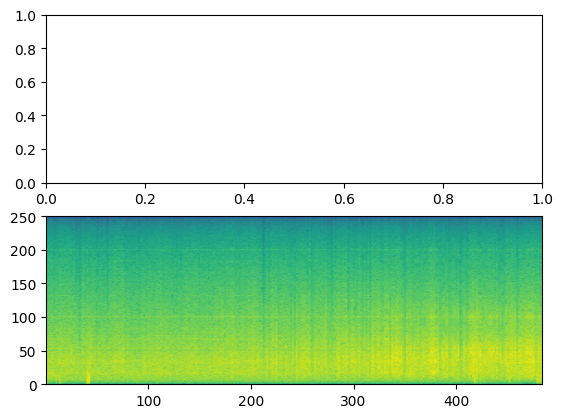

In [0]:
####   spectrogram display   ###
#filt,zi_notch = signal.lfilter(b_notch, a_notch, vec,zi=zi_notch)
#filt,zi_band = signal.lfilter(b_band, a_band, filt,zi=zi_band)

filt,zi_notch,zi_band = Filter_data(vec,a_notch,b_notch,a_band,b_band,zi_notch,zi_band)
f_1, t_1, spectro1  = signal.spectrogram(filt[1],nperseg=1024)
fig, (ax1,ax2) = plt.subplots(2)
freqs1 = fft.fftshift(fft.fft(filt[1]))

spec,f,t,im = ax2.specgram(filt[1],NFFT=1024,Fs=500)
ax1.plot(np.linspace(-fs/2, fs/2, 200000),abs(freqs1))
ax2.axes.set_ylim(bottom=10,top=20)
ax1.axes.set_xlim(left=15,right=19)
plt.show()

In [0]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(t_1, f_1*fs)
surf = ax.plot_surface(X, Y, spectro1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#ax.set_xlim3d(left=0,right=15000)
ax.set_ylim3d(bottom=0,top=20)
plt.show()

<function matplotlib.pyplot.show>

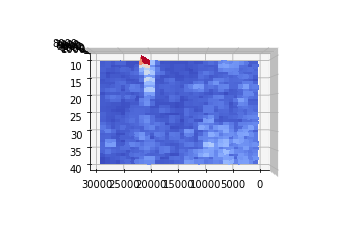

In [0]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure()
ax = fig.gca(projection='3d')
vec = raw_data.get_data(start=0,stop = 30000)
f_1, t_1, spectro1  = signal.spectrogram(vec[i],nperseg=1024)
spectro_crop = spectro1[(f_1<=(highcut/fs)) & (f_1>=(lowcut/fs))][:]
np.size(spectro_crop,0)
f_1_crop=f_1[(f_1<=(highcut/fs)) & (f_1>=(lowcut/fs))]
X, Y = np.meshgrid(t_1,f_1_crop*fs)
surf = ax.plot_surface(X,Y,spectro_crop,cmap=cm.coolwarm,linewidth=0,antialiased=False)
ax.view_init(90, 90)
plt.show

Extracting parameters from EEG_Data_03.vhdr...
Setting channel info structure...


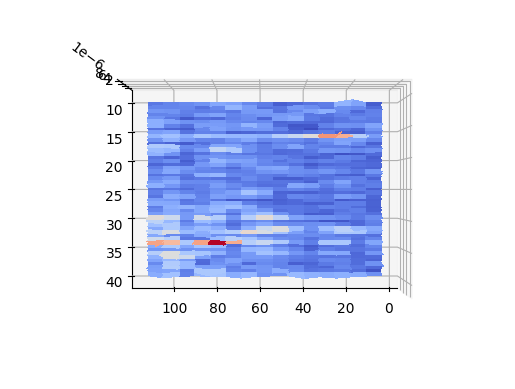

<function matplotlib.pyplot.show>

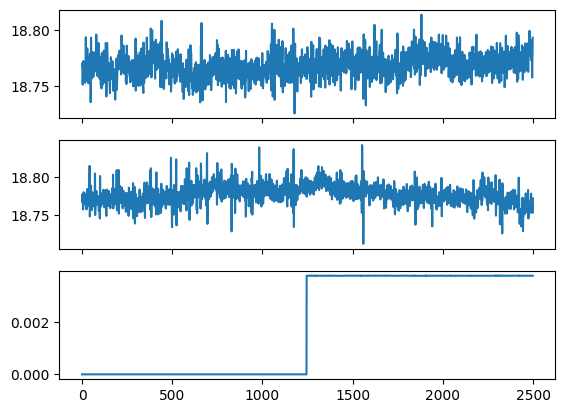

In [0]:
corr_cz = signal.correlate(data_info[23][0:2499],signal.unit_impulse(2500,5),mode='same')/5000
np.size(corr_cz)
time = np.arange(0,5000,1)
fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1, sharex=True)
ax_orig.plot(data_info[23][0:2499])
ax_noise.plot(data_info[23][-2500:])
ax_corr.plot(corr_cz)
plt.show

In [0]:
data_info[23][0:2499] == data_info[23][2500:4999]

array([False, False, False, ..., False, False, False])

# New Section